Настроим JupyterNotebook.

In [89]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Импортируем необходимые библиотеки и файлы.

In [90]:
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Polygon, AntPath
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from config import settings

Мы провели варьирование параметров поиска оптимального маршрута для области "novorossiysk" в следующих диапазонах:

In [91]:
params_ranges = {
    "population_size": [32],
    "selection_rate": [0.4, 0.45, 0.5, 0.55, 0.6, 0.66, 0.667, 0.7],
    "parents_count": [2, 3, 4],
    "mutants_rate": [0, 0.05, 0.1, 0.15, 0.2],
    "parents_choice_type": ["panmixia", "inbreeding", "outbreeding"],
    "parents_similarity_type": ["fitness", "combination"],
    "mutation_swap_value": [0.01, 0.05, 0.07, 0.1, 0.13],
    "route_distance_weight": [1],
    "route_turns_angle_weight": [1],
    "route_self_intersection_weight": [1],
    "repair_route_genotypes": [False, True]
}
for param_name, param_range in params_ranges.items():
    print(param_name, param_range)

population_size [32]
selection_rate [0.4, 0.45, 0.5, 0.55, 0.6, 0.66, 0.667, 0.7]
parents_count [2, 3, 4]
mutants_rate [0, 0.05, 0.1, 0.15, 0.2]
parents_choice_type ['panmixia', 'inbreeding', 'outbreeding']
parents_similarity_type ['fitness', 'combination']
mutation_swap_value [0.01, 0.05, 0.07, 0.1, 0.13]
route_distance_weight [1]
route_turns_angle_weight [1]
route_self_intersection_weight [1]
repair_route_genotypes [False, True]


Покажем данную область на карте с точками начала и завершения полётной миссии.

In [ ]:
novorossiysk_polygon = Polygon(
    locations=settings.area_samples.novorossiysk.survey_area_points,
    stroke_color='blue',
    fill_color='blue'
)

points = [
    settings.area_samples.novorossiysk.start_point,
    settings.area_samples.novorossiysk.end_point
]
points_info = [
    {"name": "Start"},
    {"name": "End"}
]
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
</dl>
"""
points_text = [info_box_template.format(**point_info) for point_info in points_info]

markers = [Marker(location=(points[i])) for i in range(len(points))]


m = Map(center=settings.area_samples.novorossiysk.start_point, zoom=11)
for i in range(len(markers)):
    markers[i].popup = HTML(points_text[i])
    m.add_layer(markers[i])
m.add_layer(novorossiysk_polygon)

m

Для 8640 комбинаций параметров выбрали 13 спотов промежуточных данных, соответствующих 13 лучшим оценкам маршрутов, чтобы посмотреть, как параметры генетического алгоритма влияют на нахождение оптимального маршрута. Загрузим эти данные, выводя значение функции приспособленности.

In [93]:
data_spots = []
for num in range(1, 14):
    filename = "analysis\\novorossiysk\\top_spots\\" + str(num) + ".npy"
    data_spots.append(np.load(filename, allow_pickle=True).all())
    print(data_spots[num - 1]["route_result"]["route_fitness"])

3.7564018115253144
3.755796977083395
3.7540995135595847
3.751151010986254
3.7493343063773112
3.7482633435822534
3.744720580623259
3.74241658817252
3.742079959844397
3.741851267194959
3.741805048291709
3.7417729808532534
3.7405026658138407


Рассмотрим какие параметры привели к нахождению наилучших результатов.

In [94]:
selection_rate = [data_spot["evolution"]["selection_rate"] for data_spot in data_spots]
parents_count = [data_spot["evolution"]["parents_count"] for data_spot in data_spots]
parents_choice_type = [data_spot["evolution"]["parents_choice_type"] for data_spot in data_spots]
parents_similarity_type = [data_spot["evolution"]["parents_similarity_type"] for data_spot in data_spots]
mutants_rate = [data_spot["evolution"]["mutants_rate"] for data_spot in data_spots]
mutations_swap_rate = [data_spot["mutations"]["swap_rate"] for data_spot in data_spots]

print("Доля выживших генотипов:")
print(selection_rate)
print("Количество родителей в группе при скрещивании:")
print(parents_count)
print("Принцип группировки родительских генотипов:")
print(parents_choice_type)
print("Тип сравнения генотипов при группировке:")
print(parents_similarity_type)
print("Доля мутированных генотипов:")
print(mutants_rate)
print("Доля перестановок в генотипе при мутации:")
print(mutations_swap_rate)

Доля выживших генотипов:
[0.667, 0.667, 0.7, 0.667, 0.667, 0.667, 0.7, 0.667, 0.667, 0.66, 0.6, 0.7, 0.6]
Количество родителей в группе при скрещивании:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]
Принцип группировки родительских генотипов:
['panmixia', 'panmixia', 'panmixia', 'panmixia', 'inbreeding', 'panmixia', 'outbreeding', 'panmixia', 'panmixia', 'outbreeding', 'inbreeding', 'panmixia', 'inbreeding']
Тип сравнения генотипов при группировке:
['fitness', 'fitness', 'fitness', 'fitness', 'combination', 'fitness', 'combination', 'combination', 'combination', 'combination', 'fitness', 'combination', 'fitness']
Доля мутированных генотипов:
[0.1, 0.15, 0, 0.1, 0.2, 0.05, 0.05, 0.2, 0.05, 0.2, 0.15, 0.1, 0.2]
Доля перестановок в генотипе при мутации:
[0.1, 0.07, 0.01, 0.05, 0.01, 0.13, 0.05, 0.07, 0.13, 0.13, 0.01, 0.01, 0.1]


Посмотрим, какова частота у тех или иных значений.

In [95]:
print("Доля выживших генотипов:")
print(dict(zip(selection_rate,[selection_rate.count(i) for i in selection_rate])))
print("Количество родителей в группе при скрещивании:")
print(dict(zip(parents_count,[parents_count.count(i) for i in parents_count])))
print("Принцип группировки родительских генотипов:")
print(dict(zip(parents_choice_type,[parents_choice_type.count(i) for i in parents_choice_type])))
print("Тип сравнения генотипов при группировке:")
print(dict(zip(parents_similarity_type,[parents_similarity_type.count(i) for i in parents_similarity_type])))
print("Доля мутированных генотипов:")
print(dict(zip(mutants_rate,[mutants_rate.count(i) for i in mutants_rate])))
print("Доля перестановок в генотипе при мутации:")
print(dict(zip(mutations_swap_rate,[mutations_swap_rate.count(i) for i in mutations_swap_rate])))

Доля выживших генотипов:
{0.667: 7, 0.7: 3, 0.66: 1, 0.6: 2}
Количество родителей в группе при скрещивании:
{2: 12, 3: 1}
Принцип группировки родительских генотипов:
{'panmixia': 8, 'inbreeding': 3, 'outbreeding': 2}
Тип сравнения генотипов при группировке:
{'fitness': 7, 'combination': 6}
Доля мутированных генотипов:
{0.1: 3, 0.15: 2, 0: 1, 0.2: 4, 0.05: 3}
Доля перестановок в генотипе при мутации:
{0.1: 2, 0.07: 2, 0.01: 4, 0.05: 2, 0.13: 3}


Оценивая долю выживших генотипов, можно сразу заметить, что отсутствуют значения, меньше чем 0.6. При них популяция быстро вырождается.
При этом, превалирует значение 0.667 - при нём размер популяции при делении генотипов в группы по 2-ое остаётся примерно на одном уровне.

По количеству родителей очевидным фаворитом выступает классическое деление на пары.

По принципу группировки родителей выигрывает панмиксия, то есть случайное объединение родителей в пары.

Тип сравнения генотипов при группировке кажется на первый взгляд примерно равно распределённым между сравнением значений приспособленности и значений позиционного веса.
Однако, если обратимся к предыдущим данным, то заметим, кое-что любопытное.

In [96]:
print("Принцип группировки родительских генотипов:")
print(parents_choice_type)
print("Тип сравнения генотипов при группировке:")
print(parents_similarity_type)

Принцип группировки родительских генотипов:
['panmixia', 'panmixia', 'panmixia', 'panmixia', 'inbreeding', 'panmixia', 'outbreeding', 'panmixia', 'panmixia', 'outbreeding', 'inbreeding', 'panmixia', 'inbreeding']
Тип сравнения генотипов при группировке:
['fitness', 'fitness', 'fitness', 'fitness', 'combination', 'fitness', 'combination', 'combination', 'combination', 'combination', 'fitness', 'combination', 'fitness']


При панмиксии мы не используем функцию сравнения генотипов для группировки. А значит, необходимо исключить эти значения из оценки частоты типов сравнения генотипов при группировке.

In [97]:
similarity_types = [parents_choice_type[i] + ":" +parents_similarity_type[i] for i,v in enumerate(parents_choice_type) if v!='panmixia']
print(similarity_types)

['inbreeding:combination', 'outbreeding:combination', 'outbreeding:combination', 'inbreeding:fitness', 'inbreeding:fitness']


Учитывая, что значения идут по убыванию их оценки приспособленности, можно сделать вывод, что использование позиционной оценки при сравнении генотипов является более предпочтительным.

Теперь рассмотрим то, как зависит максимальная приспособленность в популяции от эволюционного цикла. Для этого построим соответствующие графики. Также, в названиях графиков укажем значения доли мутированных генотипов и доли перестановок при мутации.

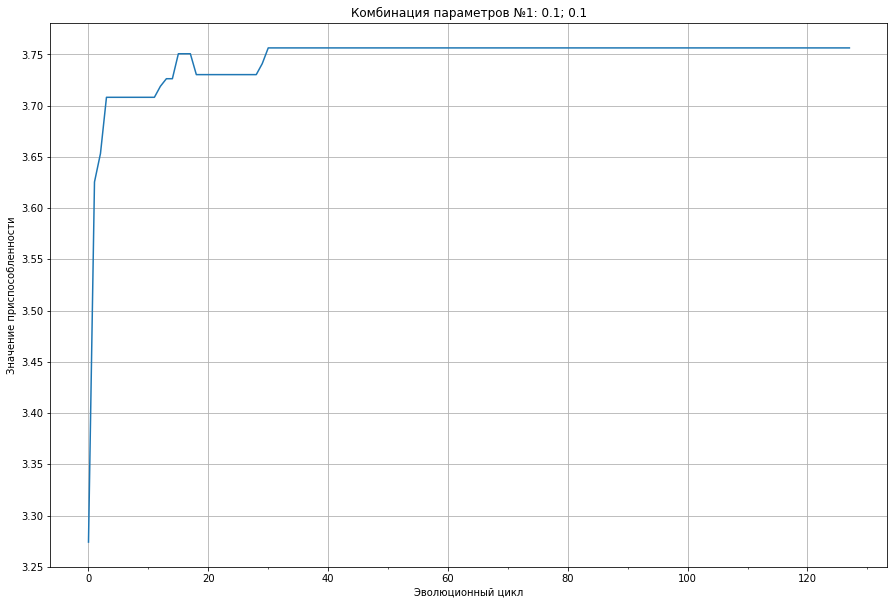

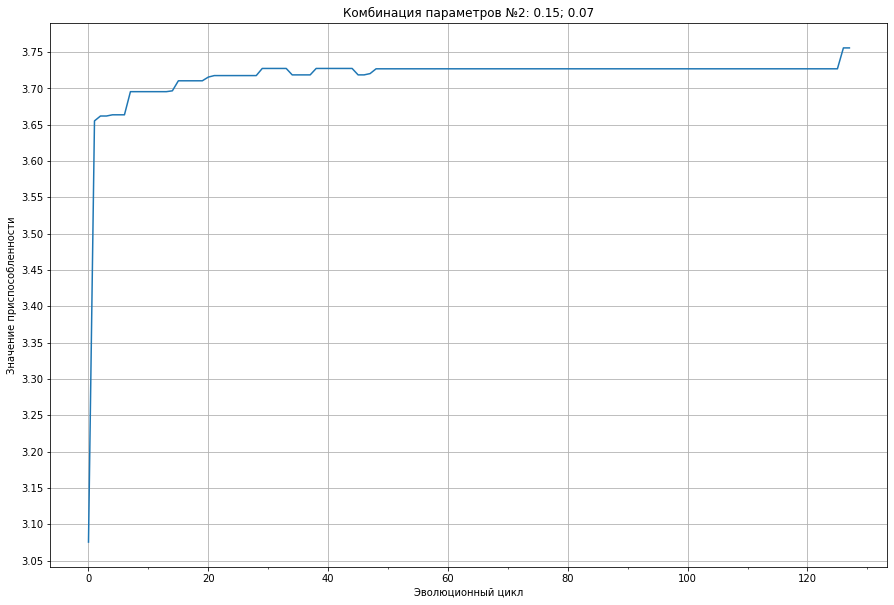

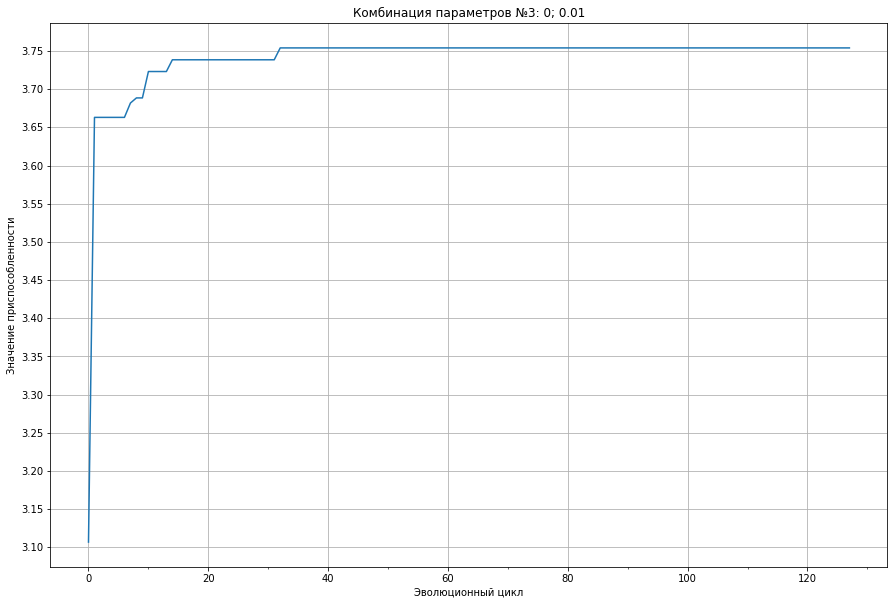

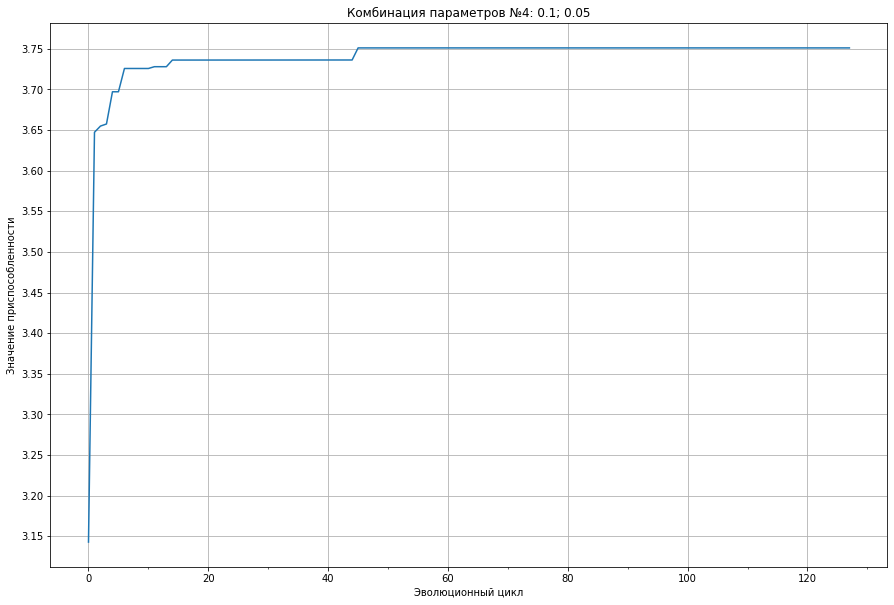

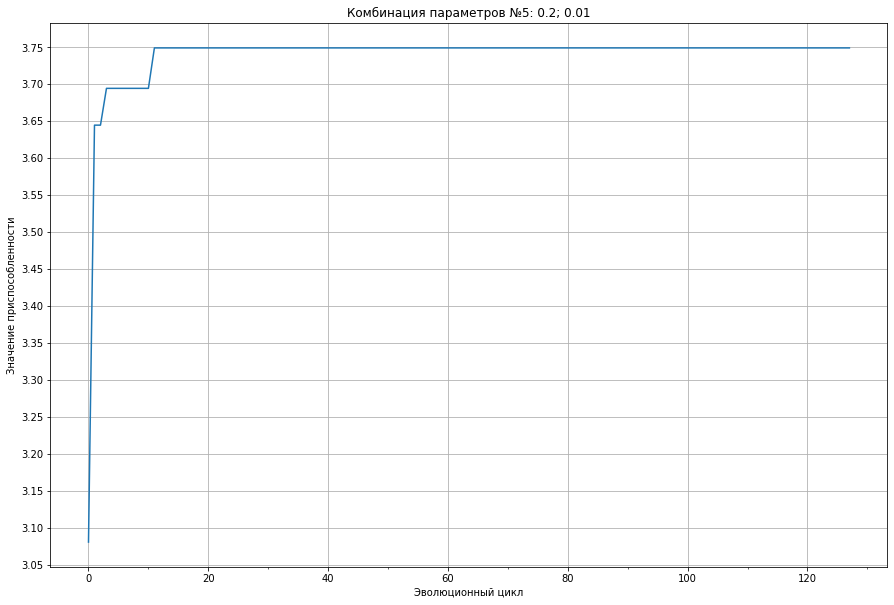

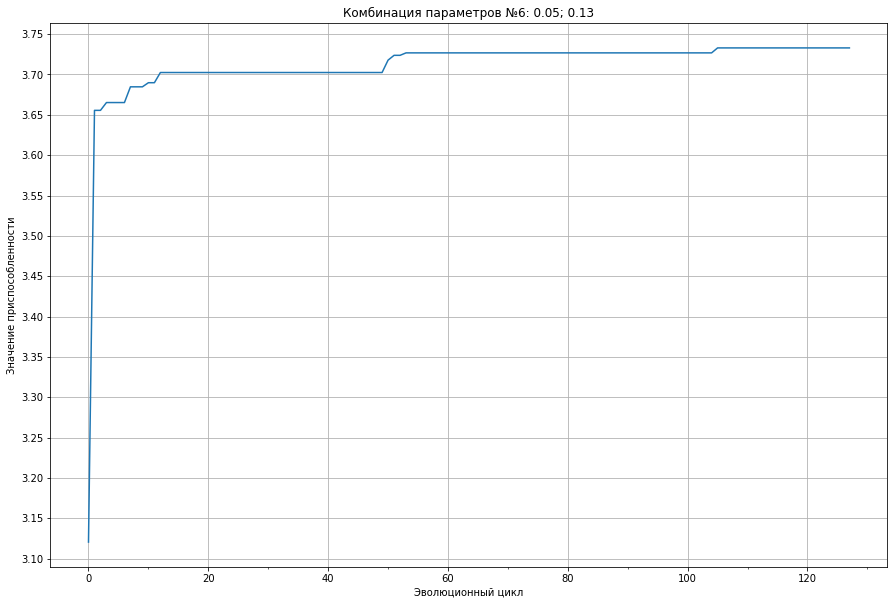

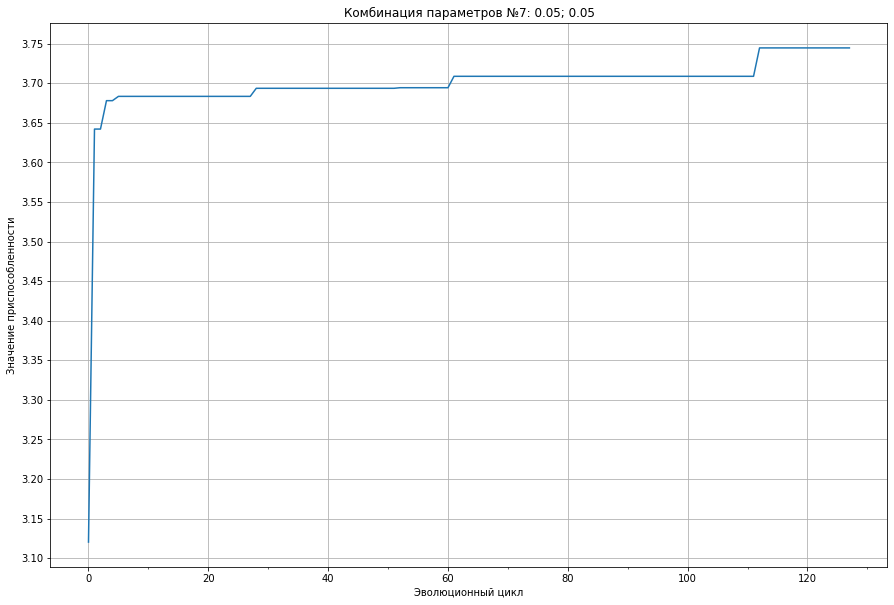

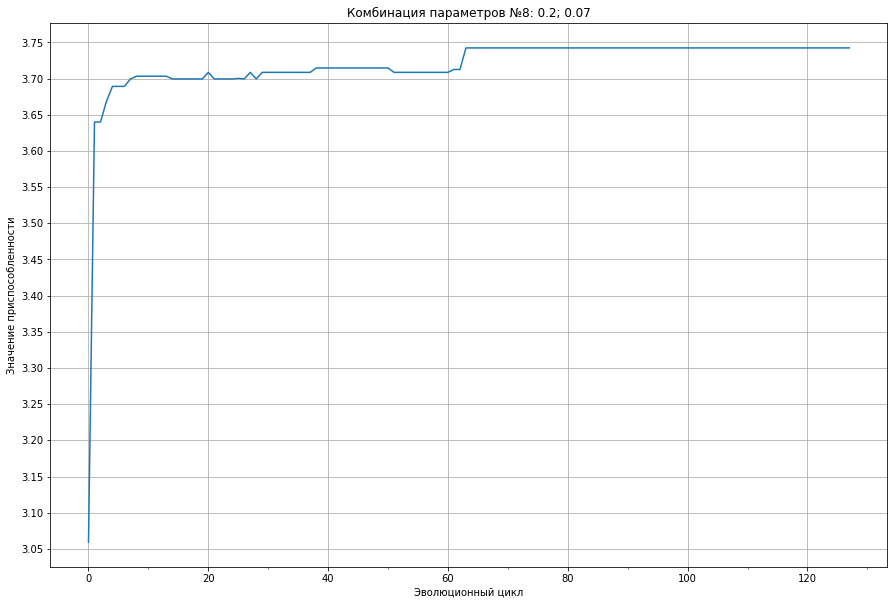

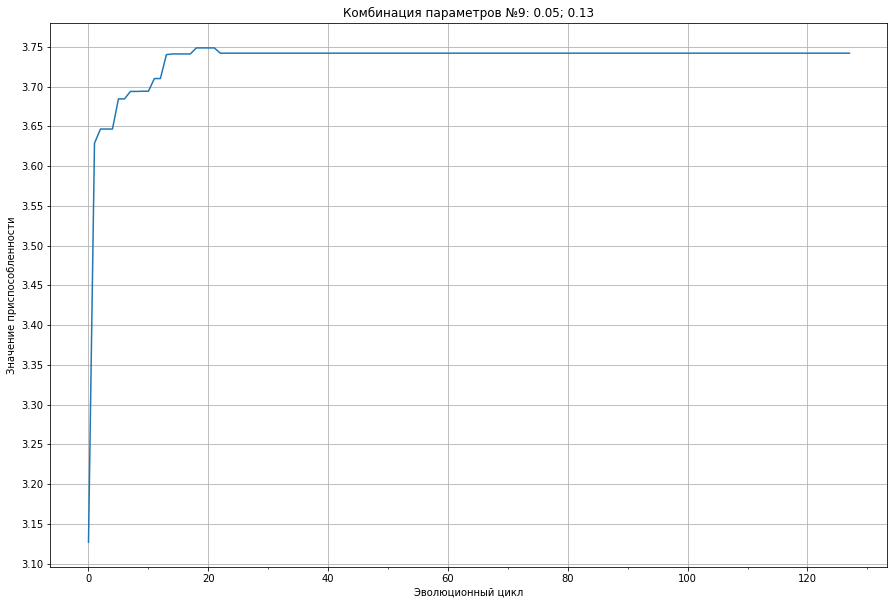

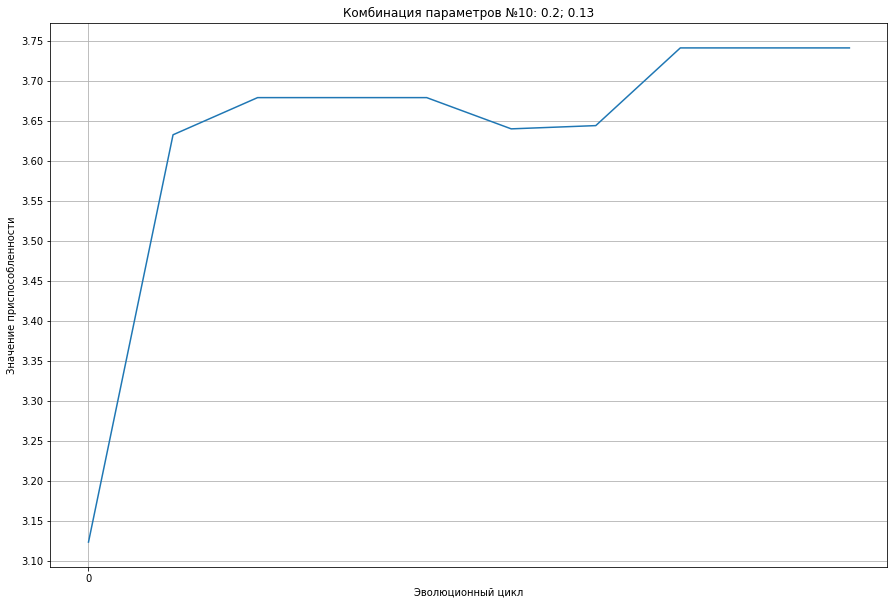

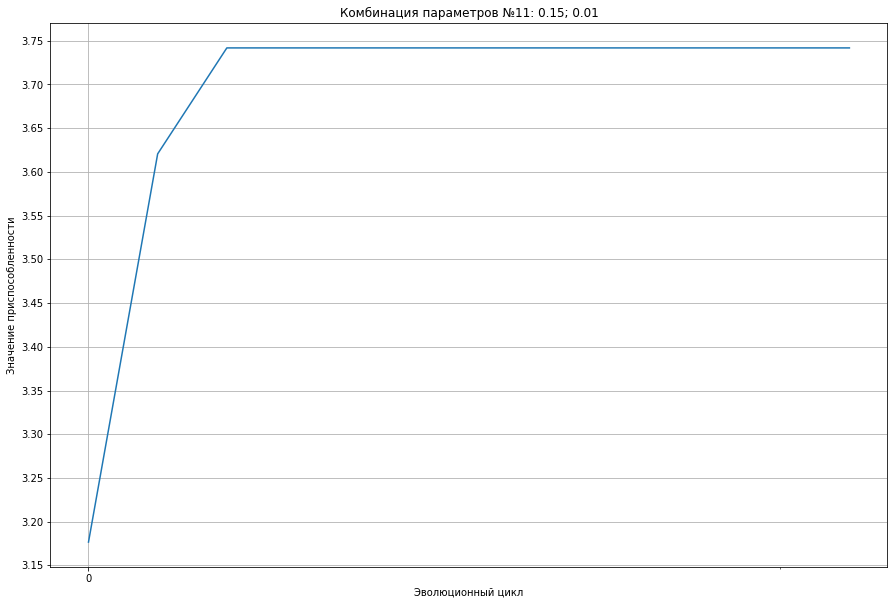

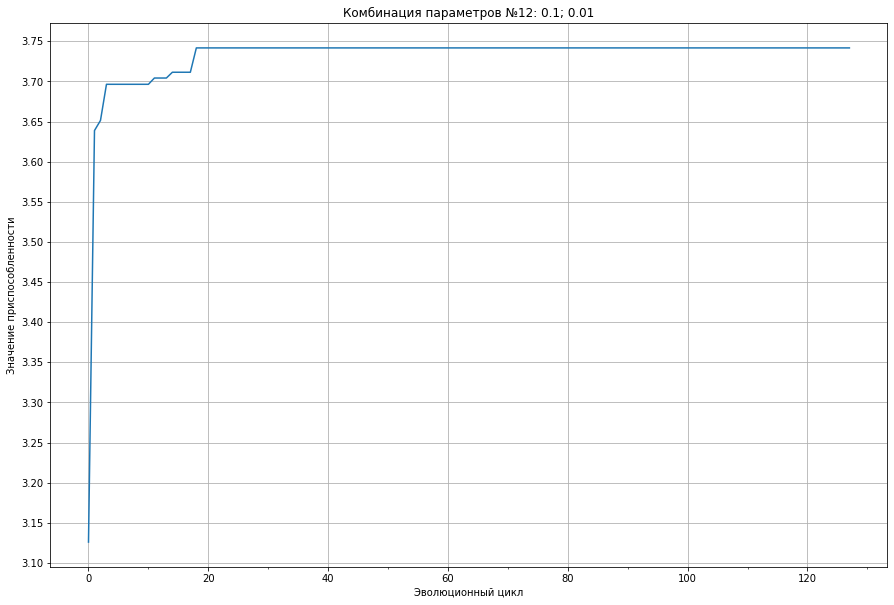

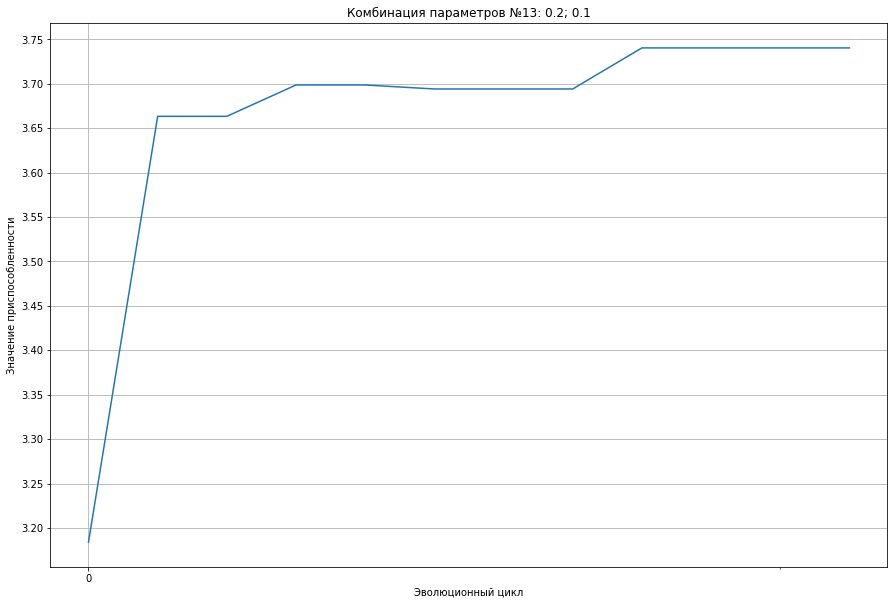

In [98]:
for data_spot_index in range(len(data_spots)):
    max_fitness = []
    offset = 0
    data_spot = data_spots[data_spot_index]
    for population in data_spot["populations"]:
        max_fitness.append(max(data_spot["estimations"][offset:offset+population["size"]]))
        offset += population["size"]

    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.set_title('Комбинация параметров №' + str(data_spot_index+1) + ": " +
                 str(data_spot["evolution"]["mutants_rate"]) + "; " +
                 str(data_spot["mutations"]["swap_rate"])
                 )
    ax.set_xlabel('Эволюционный цикл')
    ax.set_ylabel('Значение приспособленности')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    ax.plot(max_fitness[:128])
    ax.grid()

Говоря о мутациях относительно полученных данных и приведённых графиков, становится понятно, что неконтролируемые мутации могут оказывать двоякий эффект. С одной стороны они увеличивают разнообразие генотипов, но с другой могут служить и причиной понижения максимальной приспособленности в популяции.

Поэтому к реализации генетического алгоритма стоит добавить правило, защищающее наиболее приспособленную особь от мутаций. Или, например, в случае мутации наиболее приспособленной особи, реплицирующее данную особь перед мутацией.

При рассмотрении долей мутированных генотипов и долей перестановок в генотипе можно прийти к выводу, что мутации должны быть ограничены небольшими значениями, и в качестве оптимальной пары можно указать: 0.1 и 0.1

Также можно заметить, что большое количество эволюционных циклов скорее избыточно. В данной работе ограничение по их количеству использовалось в качестве критерия останова, но будет оптимальнее добавить критерии, основанные на целевом значении функции приспособленности, при достижении которого завершается поиск, или основанные на приращении функции приспособленности и его сравнении с заданной точностью.

Таким образом на основе имеющихся данных можно выбрать следующую комбинацию параметров в качестве приоритетной.

In [99]:
optimal_params = {
    "population_size": 32,
    "selection_rate": 0.667,
    "parents_count": 2,
    "mutants_rate": 0.1,
    "max_lifecycles": 64,
    "parents_choice_type": "panmixia",
    "parents_similarity_type": "combination",
    "mutation_swap_value": 0.1,
    "mutation_swap_type": "rate",
    "repair_route_genotypes": True
}

Теперь посмотрим оптимальный найденный машрут для области "novorossiysk".

In [ ]:
def show_route_result(
        start_point,
        area_points,
        end_point,
        route_result
):
    area_polygon = Polygon(
        locations=area_points,
        stroke_color='blue',
        fill_color='blue'
    )

    start_end_points = [
        start_point,
        end_point
    ]
    start_end_points_info = [
        {"name": "Start"},
        {"name": "End"}
    ]
    info_box_template = """
    <dl>
    <dt>Name</dt><dd>{name}</dd>
    </dl>
    """
    start_end_points_text = [info_box_template.format(**point_info) for point_info in start_end_points_info]

    start_end_markers = [Marker(location=(start_end_points[i])) for i in range(len(start_end_points))]

    ant_path = AntPath(
        locations=[
            start_point,
            route_result["in_point"],
            *route_result["route"],
            route_result["out_point"],
            end_point
        ],
        dash_array=[1, 10],
        delay=1000,
        color='#7590ba',
        pulse_color='#3f6fba'
    )

    route_m = Map(center=start_point, zoom=9)

    for i in range(len(markers)):
        start_end_markers[i].popup = HTML(start_end_points_text[i])
        route_m.add_layer(start_end_markers[i])
    route_m.add_layer(area_polygon)
    route_m.add_layer(ant_path)

    return route_m

show_route_result(
    settings.area_samples.novorossiysk.start_point,
    settings.area_samples.novorossiysk.survey_area_points,
    settings.area_samples.novorossiysk.end_point,
    data_spots[0]["route_result"]
)

После чего применим генератор маршрута для других областей с выбранными настройками.

In [101]:
data_spots = []
data_spots.append(np.load("analysis/gdynia_route.npy", allow_pickle=True).all())
data_spots.append(np.load("analysis/odessa_route.npy", allow_pickle=True).all())
data_spots.append(np.load("analysis/pionersky_route.npy", allow_pickle=True).all())

In [ ]:
show_route_result(
    settings.area_samples["gdynia"].start_point,
    settings.area_samples["gdynia"].survey_area_points,
    settings.area_samples["gdynia"].end_point,
    data_spots[0]["route_result"]
)

In [ ]:
show_route_result(
    settings.area_samples["odessa"].start_point,
    settings.area_samples["odessa"].survey_area_points,
    settings.area_samples["odessa"].end_point,
    data_spots[1]["route_result"]
)

In [ ]:
show_route_result(
    settings.area_samples["pionerskiy"].start_point,
    settings.area_samples["pionerskiy"].survey_area_points,
    settings.area_samples["pionerskiy"].end_point,
    data_spots[2]["route_result"]
)

В заключение можно сказать, что все полученные результаты использовали веса для критериев наименьшей дистанции, наибольшей плавности маршрута и наименьшего количества самопересечений, равные 1.0, 1.0, 1.0 соответственно. Поэтому, при необходимости поставить акцент на тот или иной критерий, веса можно изменить в файле настроек.